In [1]:
""" Python Standard Library """
import os
import datetime as dt
import json
import logging
""" Third Party Imports """
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
""" Local Imports """
if 'requirements.txt' not in os.listdir(os.getcwd()):
    os.chdir(os.path.join('..','..','..'))
print(os.getcwd())
from covid_model.model import CovidModel
from covid_model.runnable_functions import do_single_fit, do_create_report
from covid_model.utils import setup, get_filepath_prefix
from covid_model.analysis.charts import plot_transmission_control

os.environ['gcp_project'] = 'co-covid-models'
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = "co-covid-models-credentials.json"

outdir = setup("qc_vaccines.ipynb")

/Users/emwu9912/PycharmProjects/covid-models


2022/10/03 13:04:38 INFO|============================================================


In [2]:
model_args = {
    'params_defs': json.load(open('covid_model/analysis/20221004_oct_gov_briefing/20221004_scenario_params.json')),
    'region_defs': 'covid_model/input/region_definitions.json',
    # you have to call the vaccine projection parameters that don't put a maximum cumulative value on each age group, that way you can project out to infinity
    'vacc_proj_params': 'covid_model/model_dev_qc/vaccines/qc_vacc_proj_params.json',
    'regions': ['co'],
    'mobility_mode': None,
    'start_date': '2020-01-24',
    'end_date': '2022-12-31',
    'max_step_size': 1.0,
    'ode_method': 'RK45',
    'hosp_reporting_frac': {"2020-01-01": 1, "2022-03-01": 0.932, "2022-03-15": 0.868, "2022-03-30": 0.8}
}
# create initial solution so we don't have to fit the whole window
model = CovidModel(**model_args)

2022/10/03 13:04:41 INFO|------------------------|{} Retrieving vaccinations data
2022/10/03 13:04:44 INFO|------------------------|{} Constructing vaccination projections
2022/10/03 13:04:44 INFO|------------------------|{} Retrieving hospitalizations data


In [3]:
#model.vacc_proj_params = 'covid_model/input/vacc_proj_params.json'
model.update_data()

In [4]:
populations = {p['attrs']['age']: list(p['vals'].values())[0] for p in model.params_defs if p['param'] == 'region_age_pop' and p['attrs']['region'] == 'co'}
pop_df = pd.DataFrame.from_dict(populations, orient='index').reset_index()
pop_df.columns = ['age', 'pop']
pop_df

,age,pop
0,0-19,1411161
1,20-39,1697671
2,40-64,1818147
3,65+,878522


In [5]:
df_actual = model.actual_vacc_df.stack(dropna=False).reset_index().rename(columns={'level_3': 'shot', 0: 'count'}).assign(type='actual')
df_proj = model.proj_vacc_df.stack(dropna=False).reset_index().rename(columns={'level_3': 'shot', 0: 'count'}).assign(type='projection')
df = pd.concat([df_actual, df_proj]).merge(pop_df)
df

,date,region,age,shot,count,type,pop
0,2020-12-14,co,20-39,shot1,112.000000,actual,1697671
1,2020-12-14,co,20-39,shot2,0.000000,actual,1697671
2,2020-12-14,co,20-39,booster1,0.000000,actual,1697671
3,2020-12-14,co,20-39,booster2,0.000000,actual,1697671
4,2020-12-15,co,20-39,shot1,156.000000,actual,1697671
...,...,...,...,...,...,...,...
11955,2022-12-30,co,0-19,booster2,254.571429,projection,1411161
11956,2022-12-31,co,0-19,shot1,216.857143,projection,1411161
11957,2022-12-31,co,0-19,shot2,221.285714,projection,1411161
11958,2022-12-31,co,0-19,booster1,397.571429,projection,1411161


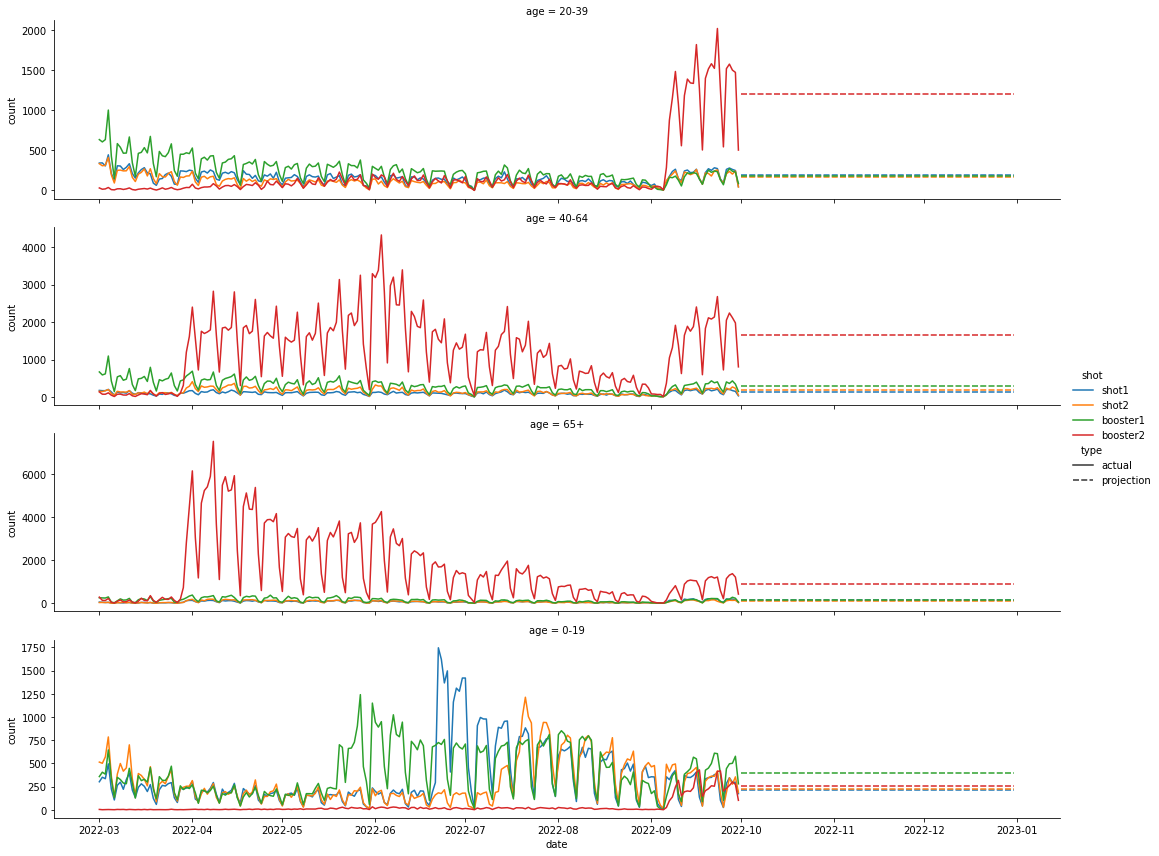

In [6]:
t1 = dt.datetime.strptime('2022-03-01', '%Y-%m-%d').date()
t2 = model.end_date
filt = (t1 <= df.date) & (df.date <= t2)
rel = sns.relplot(data=df.loc[filt,:], kind='line', 
                  x='date', y='count', row='age', hue='shot', style='type', 
                  height=3, aspect=5, facet_kws={'sharey': False})

In [7]:
rel.savefig(get_filepath_prefix(outdir) + '_vacc_projections.png')

# Estimate out what proportion of vaccinated people 0-19 are <5

In [ ]:
df019 = df.loc[df['age'] == '0-19']
df019['lt5'] = False
df019.loc[(df019['shot'] == 'shot1') & (df019['date'] > dt.datetime.strptime('2022-06-10', '%Y-%m-%d').date()),'lt5'] = True
dflt5 = df019[['date', 'shot', 'count', 'lt5']].groupby(['date', 'shot', 'lt5']).aggregate(count=('count', 'sum')).reset_index('lt5')
dflt5cs = dflt5.pivot(columns='lt5', values='count').fillna(0).sort_index().groupby('shot').cumsum()
dflt5cs['prop_lt5'] = dflt5cs[True] / dflt5cs.sum(axis=1)
dflt5cs = dflt5cs['prop_lt5'].reset_index('shot').pivot(columns='shot', values='prop_lt5')
tfilter = dflt5cs.index.get_level_values(0) > dt.datetime.strptime('2022-06-01', '%Y-%m-%d').date()
ax = dflt5cs.loc[tfilter,:].plot(figsize=(15, 8))
plt.xticks(rotation = 45, ha='right')
plt.axvline(x=dt.datetime.strptime('2022-10-04', '%Y-%m-%d').date(), linestyle='--', color='grey')

In [ ]:
dfbooster3 = df.loc[df['shot'] == 'booster3']
dfbooster3.loc[(dfbooster3['shot'] == 'booster3')] = True
dfbooster3cs = dflt5.pivot(columns='booster3', values='count').fillna(0).sort_index().groupby('shot').cumsum()
dfbooster3cs['prop_booster3'] = dflt5cs[True] / dflt5cs.sum(axis=1)
dfbooster3cs = dflt5cs['prop_lt5'].reset_index('shot').pivot(columns='shot', values='prop_lt5')
tfilter = dfbooster3cs.index.get_level_values(0) > dt.datetime.strptime('2022-08-01', '%Y-%m-%d').date()
ax = dfbooster3cs.loc[tfilter,:].plot(figsize=(15, 8))
plt.xticks(rotation = 45, ha='right')
plt.axvline(x=dt.datetime.strptime('2022-10-04', '%Y-%m-%d').date(), linestyle='--', color='grey')

In [ ]:
fig = ax.get_figure()
fig.savefig(get_filepath_prefix(outdir) + '_vacc_prop_lt5_proj.png')

# What proportion of the populations are vaccinated?

In [ ]:
dfcs = df.sort_values(['date'])
dfcs['count_cs'] = dfcs.groupby(['region', 'age', 'shot']).cumsum(axis=0)

In [ ]:
rel = sns.relplot(data=dfcs, kind='line', 
                  x='date', y='count_cs', row='age', hue='shot', style='type', 
                  height=3, aspect=4, facet_kws={'sharey': False})
for ax in rel.axes.flat:
    group_pop = [pop for age, pop in populations.items() if age in ax.get_title()][0]
    ax.axhline(group_pop, ls='-', color='grey')

In [ ]:
rel.savefig(get_filepath_prefix(outdir) + '_vacc_projections_cumulative.png')